In [1]:
# !git clone https://github.com/Jsrsky/machine_unlearning_experiments
# %cd machine_unlearning_experiments/experiments/animal_faces/fisher

Cloning into 'machine_unlearning_experiments'...
remote: Enumerating objects: 465, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 465 (delta 14), reused 34 (delta 9), pack-reused 374 (from 3)
Receiving objects: 100% (465/465), 628.99 MiB | 37.90 MiB/s, done.
Resolving deltas: 100% (149/149), done.
Updating files: 100% (69/69), done.
/kaggle/working/machine_unlearning_experiments/experiments/animal_faces/fisher


## Dependecies

In [2]:
from pathlib import Path
import sys
import copy
from torchvision import datasets
from tqdm.notebook import tqdm

## Utils 

In [3]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
data_root = project_root / 'data'
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook
setup_notebook()

Notebook setup completed. Project root added to sys.path: /kaggle/working/machine_unlearning_experiments


In [4]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed
set_seed()

from utils.utils import save_model

from models.effnetb0 import load_model_effnetb0, init_model_effnetb0

# Merics 
from utils.train_test_metrics import test_model, show_metrics

# Recreate Dataloaders from json files
from methods.naive.naive_utils import recreate_dataloaders

# Fisher Information Matrix (FIM) calc and unlearning with FIM
from methods.fisher.fisher_utils import iterative_fisher_unlearn, create_unlearning_dataloader

Device used: cuda


## Parameters (arbitrary chosen)

In [5]:
BATCH_SIZE = 256
MINI_BATCH_SIZE = 4096

SIGMA = 1

EPS = 1e-6
MAX_NORM = 0

# CALL FISHER

### Files

In [6]:
model_file = project_root / 'experiments/animal_faces/naive/EffNetB0_AFHQ_model.pth'
samples_to_unlearn_file = project_root / 'experiments/animal_faces/naive/afhq_samples_to_unlearn_30per.json'
remaining_dataset_file = project_root / 'experiments/animal_faces/naive/updated_afhq_data_splits.json'

### Init models

In [7]:
original_model, original_model_name, criterion, _optimizer, transform = load_model_effnetb0(model_pth_path=model_file)

model_to_unlearn = copy.deepcopy(original_model)
import torch.nn as nn
model_to_unlearn = nn.DataParallel(model_to_unlearn, device_ids=[0, 1])

model_to_unlearn_name = 'fisher_' + original_model_name

Load model...
Init model...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 132MB/s] 


Done initializing model.
Model ID: 132825625794864, Optimizer ID: 132825625795584, Criterion ID: 132825625795536
Done loading model.


## Init data

In [8]:
data_root = Path('/kaggle/input/animal-faces')

In [9]:
train_dataset = datasets.ImageFolder(root=data_root/'afhq/train', transform=transform)
test_dataset = datasets.ImageFolder(root=data_root/'afhq/val', transform=transform)

In [10]:
unlearn_indices, _unlearn_loader = create_unlearning_dataloader(samples_to_unlearn_file, train_dataset, batch_size = MINI_BATCH_SIZE)

In [11]:
# train_loader, _val_loader, test_loader, classes = recreate_dataloaders(
#     data_splits_file=remaining_dataset_file,
#     datasets=(train_dataset, test_dataset), 
#     batch_size=BATCH_SIZE)

# unlearn_loader = create_unlearning_dataloader(samples_to_unlearn_file, train_dataset, batch_size = MINI_BATCH_SIZE)

### FIM

In [12]:
import math
import json
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset

from utils.utils import DEVICE

def compute_gradient_on_subset(model, criterion, dataset_subset, batch_size):
    """
    Compute the average gradient Δ_rem = ∇L(θ, D') over the given dataset_subset.
    """
    dataloader = DataLoader(dataset_subset, batch_size=batch_size, shuffle=False)
    
    grad_dict = {}
    total_samples = 0

    model.train()
    for inputs, targets in tqdm(dataloader, desc="Computing gradients"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        current_batch = inputs.size(0)
        total_samples += current_batch
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                if name not in grad_dict:
                    grad_dict[name] = param.grad.detach().clone() * current_batch
                else:
                    grad_dict[name] += param.grad.detach() * current_batch

    # Average gradients over the entire subset
    for name in grad_dict:
        grad_dict[name] /= total_samples

    return grad_dict

def compute_fisher_on_subset(model, criterion, dataset_subset, batch_size):
    """
    Compute a diagonal approximation of the Fisher Information Matrix F over the given dataset_subset.
    It averages the squared gradients.
    """
    dataloader = DataLoader(dataset_subset, batch_size=batch_size, shuffle=False)
    fisher_diag = {}
    total_samples = 0

    model.eval()
    for inputs, targets in tqdm(dataloader, desc="Computing Fisher"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        current_batch = inputs.size(0)
        total_samples += current_batch
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                if name not in fisher_diag:
                    fisher_diag[name] = (param.grad.detach() ** 2) * current_batch
                else:
                    fisher_diag[name] += (param.grad.detach() ** 2) * current_batch

    for name in fisher_diag:
        fisher_diag[name] /= total_samples

    return fisher_diag
    # for name in fisher_diag:
    #     fisher_diag[name] /= total_samples
    # fisher_diag['_total_samples'] = total_samples

    return fisher_diag

def remove_from_fisher_incrementally(fisher_diag, model, criterion, dataset_removed, batch_size):
    dataloader = DataLoader(dataset_removed, batch_size=batch_size, shuffle=False)
    total_removed_samples = 0

    model.eval()
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        batch_samples = inputs.size(0)
        total_removed_samples += batch_samples
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                fisher_diag[name] -= (param.grad.detach() ** 2) * batch_samples

    total_samples_remaining = fisher_diag['_total_samples'] - total_removed_samples
    for name in fisher_diag:
        if name != '_total_samples':
            fisher_diag[name] = torch.clamp(fisher_diag[name], min=1e-8)
            fisher_diag[name] /= total_samples_remaining
    fisher_diag['_total_samples'] = total_samples_remaining

    return fisher_diag

def iterative_fisher_unlearn(model, criterion, full_dataset, removal_indices, sigma, deletion_batch_size, compute_batch_size, eps, max_norm):
    """
    Implements the iterative Fisher unlearning procedure following theory:
    
    Inputs:
      - model: a pretrained PyTorch model (trained on full dataset D).
      - criterion: loss function (e.g., CrossEntropyLoss).
      - full_dataset: the full training dataset D (e.g., MNIST training set).
      - removal_indices: list of indices (from the JSON file) to be deleted (Dₘ). E.g., 6000 samples.
      - sigma: noise parameter σ.
      - deletion_batch_size: desired mini-batch size for deletion (m′). E.g., 1000.
      - compute_batch_size: batch size used when computing gradients/Fisher (BATCH_SIZE).
      - eps: for numerical stability
    
    Procedure:
      1. Let current_indices = set(range(len(full_dataset))).
      2. Partition removal_indices into mini-batches of size deletion_batch_size.
      3. For each mini-batch, update current_indices by removing those indices.
      4. Create a Subset from full_dataset using current_indices (this is D').
      5. Compute Δ_rem and diagonal Fisher F on D' and update model:
             θ ← θ − F⁻¹ Δ_rem + σ · F^(–1/4) · ε.
    """
    full_size = len(full_dataset)
    current_indices = set(range(full_size))

    # Partition removal_indices into mini-batches, where s = m /m'
    removal_list = list(removal_indices)
    num_batches = math.ceil(len(removal_list) / deletion_batch_size)
    partitioned_removals = [removal_list[i * deletion_batch_size : (i + 1) * deletion_batch_size] for i in range(num_batches)]
    print(f"Total deletion samples: {len(removal_list)}; partitioned into {num_batches} mini-batches (each up to {deletion_batch_size} samples).")

    # NEWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW
    # fisher_diag = compute_fisher_on_subset(model, criterion, full_dataset, compute_batch_size)
    # NEWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW
    # Iterate over each deletion mini-batch
    for i, batch in enumerate(tqdm(partitioned_removals, desc="Fisher step over mini-batches")):
        # Remove the current batch of indices from current_indices
        current_indices -= set(batch)
        updated_indices = sorted(list(current_indices))
        # Create a Subset corresponding to the updated dataset D' = D \ (deleted so far)
        dataset_remaining = Subset(full_dataset, updated_indices)
        print(f"Iteration {i+1}/{num_batches}: Remaining dataset size = {len(dataset_remaining)}")
        # NEWWWWWWWWWWWWWWWWWWWWWWWWWW
        # dataset_removed = Subset(full_dataset, batch)
        # fisher_diag = remove_from_fisher_incrementally(fisher_diag, model, criterion, dataset_removed, compute_batch_size)
        # NEWWWWWWWWWWWWWWWWWWWWWWWWWWW
        # Compute the average gradient and diagonal Fisher on D'
        grad_dict = compute_gradient_on_subset(model, criterion, dataset_remaining, compute_batch_size)
        fisher_diag = compute_fisher_on_subset(model, criterion, dataset_remaining, compute_batch_size)
        # Update model parameters using the Newton correction and noise injection
        with torch.no_grad():
            for name in grad_dict:
                grad = grad_dict[name]
                norm = grad.norm(2).item()
                grad_min = grad.min().item()
                grad_max = grad.max().item()
                grad_mean = grad.mean().item()
                grad_std = grad.std().item()
                print(f"[Raw] Param {name}: norm = {norm:.4e}, min = {grad_min:.4e}, max = {grad_max:.4e}, mean = {grad_mean:.4e}, std = {grad_std:.4e}")
            
            # First, compute and clip gradients, and monitor norms
            total_grad_norm_before = 0.0
            total_grad_norm_after = 0.0
            for name in grad_dict:
                norm_before = grad_dict[name].norm(2)
                total_grad_norm_before += norm_before.item()
                if norm_before > max_norm:
                    grad_dict[name] = grad_dict[name] * (max_norm / norm_before)
                norm_after = grad_dict[name].norm(2)
                total_grad_norm_after += norm_after.item()
            
            print(f"Iteration {i+1}: Total gradient norm before clipping = {total_grad_norm_before:.4f}")
            print(f"Iteration {i+1}: Total gradient norm after clipping  = {total_grad_norm_after:.4f}")
            
            # Now, update model parameters using the clipped gradients and monitor the Newton update norm
            total_update_norm = 0.0
            for name, param in model.named_parameters():
                if param.requires_grad:
                    inv_fisher = (fisher_diag[name] + eps).pow(-1)
                    newton_update = inv_fisher * grad_dict[name]
                    total_update_norm += newton_update.norm(2).item()
                    param.data = param.data - newton_update

                    inv_fisher_quarter = (fisher_diag[name] + eps).pow(-0.25)
                    noise = torch.randn_like(param.data)
                    param.data = param.data + sigma * inv_fisher_quarter * noise

            print(f"Iteration {i+1}: Total Newton update norm = {total_update_norm:.4f}")
        print(f"Iteration {i+1}/{num_batches} update completed.")
        
    return model

In [13]:
import time
start_time = time.perf_counter()

unlearned_model = iterative_fisher_unlearn(
    model_to_unlearn,
    criterion,
    train_dataset,
    unlearn_indices,
    SIGMA,
    deletion_batch_size=MINI_BATCH_SIZE,
    compute_batch_size=BATCH_SIZE,
    eps=EPS,
    max_norm=MAX_NORM,
)

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Total deletion samples: 4389; partitioned into 2 mini-batches (each up to 4096 samples).


Fisher step over mini-batches:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration 1/2: Remaining dataset size = 10534



Computing gradients:   0%|          | 0/42 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):

Computing gradients: 100%|██████████| 42/42 [02:46<00:00,  3.97s/it]

Computing Fisher: 100%|██████████| 42/42 [01:42<00:00,  2.43s/it]


[Raw] Param module.features.0.0.weight: norm = 3.3150e-01, min = -2.9391e-02, max = 4.7486e-02, mean = 1.0985e-03, std = 1.1231e-02
[Raw] Param module.features.0.1.weight: norm = 1.8904e-02, min = -8.9379e-03, max = 1.5036e-02, mean = 5.0658e-04, std = 3.3560e-03
[Raw] Param module.features.0.1.bias: norm = 9.9462e-03, min = -3.6006e-03, max = 7.5153e-03, mean = 7.7016e-05, std = 1.7847e-03
[Raw] Param module.features.1.0.block.0.0.weight: norm = 1.6808e-01, min = -2.1375e-02, max = 4.1554e-02, mean = 2.0867e-03, std = 9.6990e-03
[Raw] Param module.features.1.0.block.0.1.weight: norm = 1.6751e-02, min = -6.9406e-03, max = 6.9170e-03, mean = 2.2151e-04, std = 3.0001e-03
[Raw] Param module.features.1.0.block.0.1.bias: norm = 8.3034e-03, min = -2.5651e-03, max = 5.8433e-03, mean = 3.3131e-04, std = 1.4528e-03
[Raw] Param module.features.1.0.block.1.fc1.weight: norm = 8.3435e-02, min = -2.7570e-02, max = 8.4323e-03, mean = -2.0893e-03, std = 4.7872e-03
[Raw] Param module.features.1.0.block

Fisher step over mini-batches:  50%|█████     | 1/2 [04:29<04:29, 269.38s/it]

Iteration 1: Total Newton update norm = 0.0000
Iteration 1/2 update completed.
Iteration 2/2: Remaining dataset size = 10241



Computing gradients: 100%|██████████| 41/41 [01:32<00:00,  2.26s/it]

Fisher step over mini-batches: 100%|██████████| 2/2 [07:35<00:00, 227.98s/it]

[Raw] Param module.features.0.0.weight: norm = 6.0849e+06, min = -1.0100e+06, max = 1.1978e+06, mean = 9.0608e+03, std = 2.0693e+05
[Raw] Param module.features.0.1.weight: norm = 2.8551e+06, min = -9.6014e+05, max = 1.7474e+06, mean = 5.2997e+04, std = 5.0996e+05
[Raw] Param module.features.0.1.bias: norm = 2.1206e+06, min = -4.2613e+05, max = 1.2971e+06, mean = 7.0823e+04, std = 3.7401e+05
[Raw] Param module.features.1.0.block.0.0.weight: norm = 8.6482e+06, min = -1.8912e+06, max = 1.9343e+06, mean = -2.5341e+04, std = 5.0986e+05
[Raw] Param module.features.1.0.block.0.1.weight: norm = 4.1192e+06, min = -2.4484e+06, max = 1.1576e+06, mean = -9.1823e+04, std = 7.3393e+05
[Raw] Param module.features.1.0.block.0.1.bias: norm = 1.1715e+07, min = -7.2861e+06, max = 4.0507e+06, mean = -2.2717e+05, std = 2.0913e+06
[Raw] Param module.features.1.0.block.1.fc1.weight: norm = 1.7334e+07, min = -2.0418e+06, max = 9.4518e+06, mean = 2.7844e+05, std = 1.0490e+06
[Raw] Param module.features.1.0.blo

### Unlearn

In [18]:
save_model(unlearned_model, f'{model_to_unlearn_name}_model.pth')

In [20]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
classes = test_dataset.classes

### Test and metrics

In [21]:
model, *_ = init_model_effnetb0()
model = nn.DataParallel(model, device_ids=[0, 1])
model_path = f"{model_to_unlearn_name}_model.pth"
test_model(model, model_to_unlearn_name, model_path, test_loader)

Init model...
Done initializing model.
Model ID: 132829041425760, Optimizer ID: 132825597979872, Criterion ID: 132825597976800
Loading and testing model: fisher_EffNetB0_AFHQ


Evaluating model: fisher_EffNetB0_AFHQ_model.pth:   0%|          | 0/6 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating model: fisher_EffNetB0_AFHQ_model.pth: 100%|██████████| 6/6 [00:12<00:00,  2.12s/it]

Predictions and labels saved to fisher_EffNetB0_AFHQ_predictions.json


Metrics for fisher_EffNetB0_AFHQ:
  - Test Accuracy: 0.3333
  - Precision: 0.1112
  - Recall: 0.3333
  - F1 Score: 0.1668


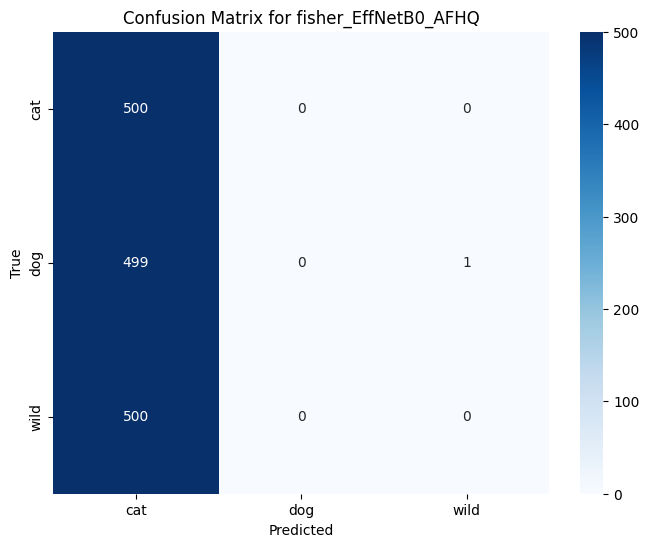

In [22]:
predictions_path = f'{model_to_unlearn_name}_predictions.json'
# classes = ['cat', 'dog', 'wildlife']
show_metrics(predictions_path, classes, model_to_unlearn_name)